<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (WIP) 06. PyTorch Transfer Learning

We've built a few models by hand so far.

But their performance has been poor.

You might be thinking, **is there a well-performing model that already exists for our problem?**

And in the world of deep learning, the answer is often *yes*.

We'll see how by using a powerful technique called [**transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning).

## TK - What is transfer learning?

* TK image - transfer learning overview

**Transfer learning** allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as [ImageNet](https://www.image-net.org/) (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a [langauge model](https://developers.google.com/machine-learning/glossary#masked-language-model) (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

## TK - Why use transfer learning?

There are two main benefits to using transfer learning:

1. Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
2. Can leverage a working model which has **already learned** patterns on similar data to our own. This often results in achieving **great results with less custom data**.

* TK image - transfer learning applied to our problem

We'll be putting these to the test for our FoodVision Mini problem, trying to classify images of pizza, steak and sushi.

## TK - Where to find pretrained models

The world of deep learning is an amazing place.

So amazing that many people around the world share their work.

Often, code and pretrained models for the latest state-of-the-art research is released within a few days of publishing.

And there are several places you can find pretrained models to use for your own problems.

| **Location** | **What's there?** | **Link(s)** | 
| ----- | ----- | ----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets | 
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ | 

* TK image - different places to find pretrained models

> **Note:** With access to such high-quality resources as above, it should be common practice at the start of every deep learning problem you take on to ask, "Does a pretrained model exist for my problem?" 

> TK links **Exercise:** Spend 5-minutes going through [`torchvision.models`](https://pytorch.org/vision/stable/models.html) as well as the [HuggingFace Hub Models page](https://huggingface.co/models), what do you find? (there's no right answers here, it's just to practice exploring) 

## TK - What we're going to cover

* TK - list this after completing the materials
* TK - Using a pretrained model from `torchvision.models` and applying it to our problem
* TK - transforming data to be used with a pretrained model from `torchvision.models`

## TK - Where can you get help?

All of the materials for this course [are available on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## TK - 0. Getting setup

Let's get started by importing/downloading the required modules for this section.

To save us writing extra code, we're going to be leveraging some of the Python scripts (such as `data_setup.py` and `engine.py`) we created in the previous section, [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

Specifically, we're going to download the [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

Now let's setup device agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## TK 1. Get data

Before we can start to use **transfer learning**, we'll need a dataset.

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using for FoodVision Mini.

Let's write some code to download the [`pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) dataset from the course GitHub and then unzip it.

We can also make sure if we've already got the data, it doesn't redownload. 

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


Excellent!

Now we've got the same dataset we've been using previously, a series of images of pizza, steak and sushi in standard image classification format.

Let's now create paths to our training and test directories.

In [4]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## TK 2. Create Datasets and DataLoaders

Since we've downloaded the `going_modular` directory, we can use the [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py) script we created in section [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy) to prepare and setup our DataLoaders.

But since we'll be using a pretrained model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), there's a specific transform we need to prepare our images first.

### 2.1 Creating a transform for `torchvision.models`

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

For the case of pretrained models in `torchvision.models`, the documentation states:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of: 

| **Transform number** | **Transform required** | **Code to perform transform** | 
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  | 

> **Note:** ^some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Wonderful!

Now we've got a series of transforms ready to prepare our images, let's create training and testing DataLoaders.

We can create these using the `create_dataloaders` function from the [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py) script we created in [05. PyTorch Going Modular Part 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

We'll set `batch_size=32` so our model see's mini-batches of 32 samples at a time.

And we can transform our images using the transform pipeline we created above by setting `transform=simple_transform`.

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1661b63ca0>,
 ['pizza', 'steak', 'sushi'])

## TK 3. Getting a pretrained model

Alright, here comes the fun part!

Over the past few notebooks we've been building PyTorch neural networks from scratch.

And while that's a good skill to have, our models haven't been performing as well as we'd like. 

That's where **transfer learning** comes in.

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customising it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... | 
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` | 
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... | 
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... | 
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` | 

### TK - 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

You might think better performance is *always better*, right?

That's true but **some better performaning models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as [The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) states, you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

For me, I've found a nice balance in the `efficientnet_bX` models. 

As of May 2022, [Nutrify](https://nutrify.app) (the machine learning powered app I'm working on) is powered by an `efficientnet_b0`.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) [uses an `efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

> **Note:** Even though we're using `efficientnet_bX`, it's important not to get too attached to any one architecture, as they are always changing as new research gets released. Best to experiment, experiment, experiment and see what works for your problem. 

### 3.2 Setting up a pretrained model

The pretrained model we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0).

The architecture is from the paper *[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)*.

* TK image - efficientnet architecture

To setup the model and make sure it comes with pretrained weights, we can set `pretrained=True`, doing so will download a set of model weights learned from the ImageNet dataset.

This means the model has already been trained on millions of images and has a good base representation of image data.

The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

> **Note:** As of December 2019, the PyTorch team announced a [new mutli-weight API for TorchVision](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/), allowing different sets of model weights (e.g. weights learned from different datasets) to be used for pretrained models. Though as of May 2022, this new API is not released. But even with the new API, the idea still remains: take the weights/patterns from one model and apply it to your own.

We'll also send it to the target device.

In [7]:
# Setup the model with pretrained weights and send it to the target device 
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model # uncomment to output (it's very long)

If we print the model, we get something similar to the following:

* TK image - turn the below into an image which describes each section

```
EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
  ...
  ...
  ...
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
  )
)
```

Lots and lots and lots of layers.

This is one of the benefits of transfer learning, taking an existing model, that's been crafted by some of the best engineers in the world and applying to your own problem.

Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default). 

### 3.3 Getting a summary of our model with `torchinfo.summary()`

To learn more about our model, let's use `torchinfo`'s [`summary()` method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [8]:
# Print a summary using torchinfo
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet                                                 --                   --                   --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─ConvNormActivation (0)                                [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

* TK image - get the torchinfo.summary() output but make it smaller so it's visible + add annotations 

Woah!

Now that's a big model!

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

For reference, our model from previous sections, **TinyVGG had 8,083 parameters vs. 5,288,548 parameters for `efficientnet_b0`, an increase of ~654x**!

What do you think, will this mean better performance?

### TK - 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

* TK image - changing the classifier head

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [9]:
# Freeze all base layers (the feature extractor in efficientnet_b0) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet. 

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

> **Note:** [Dropout layers](https://developers.google.com/machine-learning/glossary#dropout_regularization) randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help to regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are *more general*). 

And we'll keep `in_features=1280` for our `Linear` output layer but we'll change the `out_features` value to the length of our `class_names` (`len(['pizza', 'steak', 'sushi']) = 3`).

Our new `classifier` layer should be on the same device as our `model`. 

In [10]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

Nice!

Output layer updated, let's get another summary of our model and see what's changed.

In [11]:
# Do a summary *after* freezing the features and changing the output classifier layer
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet                                                 --                   --                   --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─ConvNormActivation (0)                                [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

* TK image - annotate the above with what's going on

Ho, ho! There's a fair few changes here!

Let's go through them:
* **Trainable column** - You'll see that many of the base layers (the ones in the `features` portion) have their Trainable value as `False`. This is because we set their attribute `requires_grad=False`. Unless we change this, these layers won't be updated during furture training.
* **Output shape of `classifier`** - The `classifier` portion of the model now has an Output Shape value of `[32, 3]` instead of `[32, 1000]`. It's Trainable value is also `True`. This means its parameters will be updated during training. In essence, we're using the `features` portion to feed our `classifier` portion a base representation of an image and then our `classifier` layer is going to learn how to base representation aligns with our problem.
* **Less trainable parameters** - Previously there was 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the `classifier` as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our `classifier` layer.

> **Note:** The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

## TK 4. Train model

Now we've got a pretraiend model that's semi-frozen and has a customised `classifier`, how about we see transfer learning in action?

To begin training, let's create a loss function and an optimizer.

Because we're still working with multi-class classification, we'll use `nn.CrossEntropyLoss()` for the loss function.

And we'll stick with `torch.optim.Adam()` as our optimizer with `lr=0.001`.



In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Wonderful! 

To train our model, we can use `train()` function we defined in the [05. PyTorch Going Modular section 04](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

The `train()` function is in the [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) script inside the [`going_modular` directory](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular). 

Let's see how long it takes to train our model for 5 epochs.

> **Note:** We're only going to be training the parameters `classifier` here as all of the other parameters in our model have been frozen.

In [13]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0894 | train_acc: 0.4492 | test_loss: 0.9214 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8697 | train_acc: 0.7734 | test_loss: 0.8036 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7769 | train_acc: 0.7734 | test_loss: 0.7404 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7244 | train_acc: 0.7422 | test_loss: 0.6488 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6426 | train_acc: 0.7812 | test_loss: 0.6254 | test_acc: 0.8968
[INFO] Total training time: 5.065 seconds


Wow!

Our model trained quite fast (~5 seconds on my local machine with a big GPU/about 10 seconds on Google Colab).

And it looks like it got quite good results too, let's investigate them further.

## 5. TK - Evaluate model

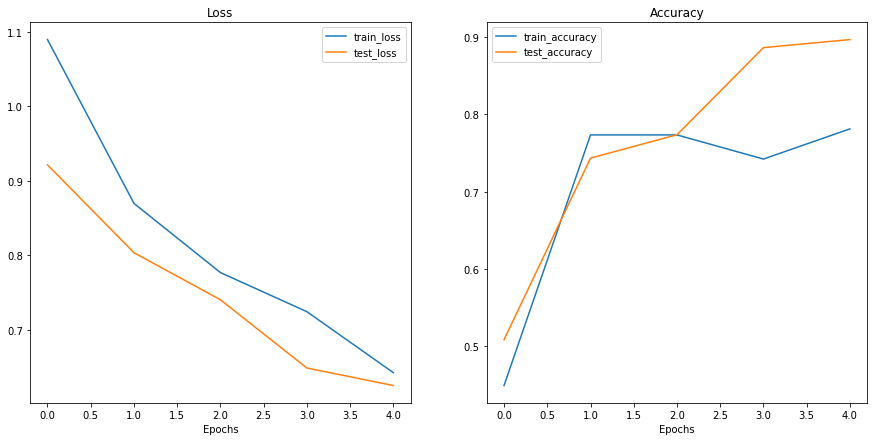

In [14]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

plot_loss_curves(results)

## TK - Make predictions with custom images (could use/create `predict.py` from previous section)

* TK - Things to remember: image has to be in *same* format model was trained on... e.g. same transforms

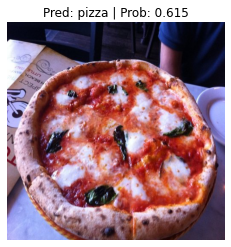

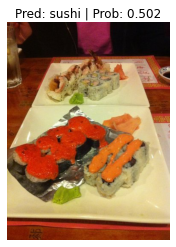

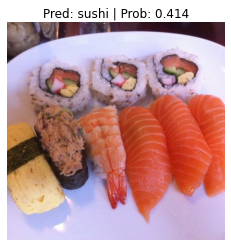

In [15]:
# Get a random image path from test set
import random
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=3)

# Open image
from PIL import Image
from typing import List, Tuple

def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str], 
                        image_size: Tuple[int, int]=(224, 224)):
    # TK - similar to function from notebook 04
    # See here for reference: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
    # Open image
    img = Image.open(image_path)

    # Create transformation for image
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])

    simple_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    normalize,
    ])

    ### Predict on image

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = simple_transform(img).unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names, 
                        image_size=(224, 224))

### TK - Pred on custom image (pizza dad)

data/04-pizza-dad.jpeg already exists, skipping download.


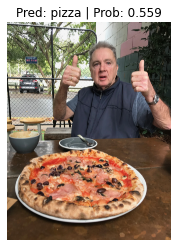

In [16]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

## TK - Extensions + Exercises
* Try a different model from PyTorch pretrained models
  * You'll have to change the size of the classifier layer
  * See here for more models: https://pytorch.org/vision/stable/models.html
  * Try ConvNext-Tiny, does it perform better than EfficientNetB0?
    * `torchvision.models.convnext_tiny()` 
* Train for longer, what happens?
* Train with more data, what happens?
  * Double the images of pizza, steak, sushi
  * Now introduce 10 classes (10 whole foods), see what happens
* Could you add in some data augmentation, what happens?
* Predict on your own image of pizza/steak/sushi - how does the model go?
* Get the "most wrong" of the predictions on the test dataset 

## TK - Extra-curriculum
* TK - Fine-tuning: if you have lots of data, this may be a good option...
* Check out the PyTorch multi-weights API (still in beta at time of writing, May 2022) - https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/